# Import Libraries

In [1]:
# Import necessary libraries
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt


# Load Data

In [3]:
from os import uname
# Mount Google Drive to access files
drive.mount('/content/drive')

# Load features and labels for monitored and unmonitored datasets

mon_features= pd.read_csv('/content/drive/MyDrive/MLproject/mon_features.csv')
mon_labels = pd.read_csv('/content/drive/MyDrive/MLproject/mon_labels.csv')
unmon_features = pd.read_csv('/content/drive/MyDrive/MLproject/unmon_features.csv')


# Combine features
features = pd.concat([mon_features, unmon_features], axis=0, ignore_index=True)

# Assign labels: monitored as 1, unmonitored as -1
mon_features['label'] = mon_labels.values
unmon_features['label'] = -1

combined_data = pd.concat([mon_features, unmon_features], axis=0, ignore_index= True)
combined_data.fillna(0, inplace=True)

X = combined_data.drop('label', axis=1)
y = combined_data['label']




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocess Data

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

# Normalize the feature values using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build and Train the Model

In [5]:
# Initialize and train the KNN model with default parameters
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test_scaled)

# Evaluate the model using accuracy and confusion matrix
acc = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation results
print(f"Accuracy: {acc}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.5841379310344827
Confusion Matrix:
[[1574    8    2 ...    1    2    3]
 [   8   18    1 ...    0    0    1]
 [  12    0   20 ...    0    0    0]
 ...
 [  12    0    0 ...    7    0    2]
 [   1    0    0 ...    0   33    0]
 [   9    3    0 ...    1    0   16]]


# Hyperparameter Tuning

In [6]:
# Define hyperparameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best parameters and model
best_params = grid_search.best_params_
best_knn_model = grid_search.best_estimator_

print(f"Best parameters (GridSearchCV): {best_params}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   1.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   1.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   1.3s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   3.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   3.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   1.9s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   2.7s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   2.9s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   1.2s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   1.1s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   1.4s
[CV] END ..metric=euclidean, n_neighbors=5, weig

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


# Evaluate the Tuned Model

In [7]:
# Predict using the best model from GridSearchCV
y_pred_tuned = best_knn_model.predict(X_test_scaled)

# Evaluate the tuned model
acc_tuned = accuracy_score(y_test, y_pred_tuned)
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
precision = precision_score(y_test, y_pred_tuned, average='macro')
recall = recall_score(y_test, y_pred_tuned, average='macro')

# Calculate ROC and Precision-Recall AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_tuned, pos_label=1)
roc_auc = auc(fpr, tpr)
precision_values, recall_values, _ = precision_recall_curve(y_test, y_pred_tuned, pos_label=1)
pr_auc = auc(recall_values, precision_values)

# Print metrics
print(f"Accuracy (Tuned Model): {acc_tuned}")
print(f"Confusion Matrix (Tuned Model):\n{conf_matrix_tuned}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")
print(f"Precision-Recall AUC: {pr_auc}")

Accuracy (Tuned Model): 0.6382758620689655
Confusion Matrix (Tuned Model):
[[1497    5    1 ...    6    3    1]
 [   8   18    0 ...    0    0    0]
 [   6    0   20 ...    1    0    0]
 ...
 [   8    0    0 ...   10    0    1]
 [   0    0    0 ...    0   41    0]
 [  11    2    0 ...    0    1   17]]
Precision: 0.5884038349370538
Recall: 0.5762017915572726
ROC AUC: 0.454493676995849
Precision-Recall AUC: 0.006574311227296475


# Visualize Results

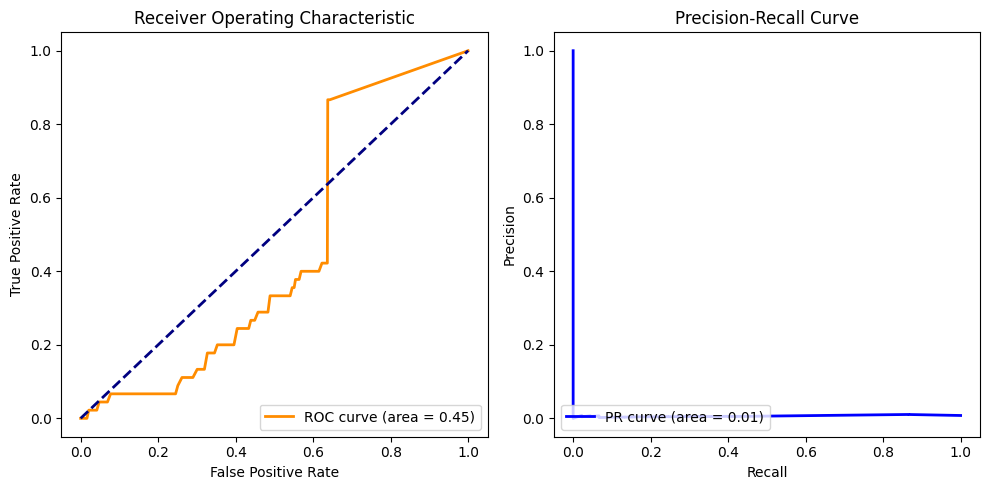

In [8]:
# Plot ROC and Precision-Recall curves
plt.figure(figsize=(10, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_values, precision_values, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()